In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import kagglehub

In [3]:
print(os.getcwd())

C:\Users\Dell\PROJECT FOR DATA SCIENCE


In [2]:

# Load dataset
dataset_path = kagglehub.dataset_download("yasserh/housing-prices-dataset")
file_path = os.path.join(dataset_path, 'Housing.csv')
df = pd.read_csv(file_path)


In [3]:

# Feature Engineering
df["total_rooms"] = df["bedrooms"] + df["bathrooms"]
df["price_per_sqft"] = df["price"] / df["area"]
df["bed_bath_ratio"] = df["bedrooms"] / (df["bathrooms"] + 1)


In [4]:
# Log Transformation for Skewed Data
df['price'] = np.log1p(df['price'])


In [5]:
# Define numerical & categorical features
num_features = ["area", "bedrooms", "bathrooms", "stories", "parking", "total_rooms", "price_per_sqft", "bed_bath_ratio"]
cat_features = ["mainroad", "guestroom", "basement", "hotwaterheating", "airconditioning", "prefarea", "furnishingstatus"]


In [6]:
# Preprocessing Pipelines
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", drop="first"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])


In [7]:
# Prepare dataset
X = df.drop("price", axis=1)
y = df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# Apply transformation
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

In [9]:
# Train Random Forest for Feature Importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_df, y_train)
feature_importance = pd.Series(rf.feature_importances_, index=X_train_df.columns)
top_features = feature_importance.sort_values(ascending=False)[:10]


In [10]:
# Select Important Features
selected_features = feature_importance[feature_importance > 0.01].index.tolist()
X_train_filtered = X_train_df[selected_features]
X_test_filtered = X_test_df[selected_features]


In [11]:
# Hyperparameter Tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

tuned_rf = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, n_jobs=-1)
tuned_rf.fit(X_train_filtered, y_train)
y_pred = tuned_rf.best_estimator_.predict(X_test_filtered)


In [12]:
# Evaluate Model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Optimized RF Model RMSE: {rmse:.2f}")
print(f"Optimized RF R² Score: {r2:.2f}")

# Stacking Regressor
stacked_model = StackingRegressor(
    estimators=[
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)),
        ('dt', DecisionTreeRegressor())
    ],
    final_estimator=LinearRegression()
)
stacked_model.fit(X_train_filtered, y_train)
y_pred_stack = stacked_model.predict(X_test_filtered)

Optimized RF Model RMSE: 0.07
Optimized RF R² Score: 0.97


In [13]:
# Evaluate Stacked Model
rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))
r2_stack = r2_score(y_test, y_pred_stack)
print(f"Stacked Model RMSE: {rmse_stack:.2f}")
print(f"Stacked Model R² Score: {r2_stack:.2f}")


Stacked Model RMSE: 0.04
Stacked Model R² Score: 0.99


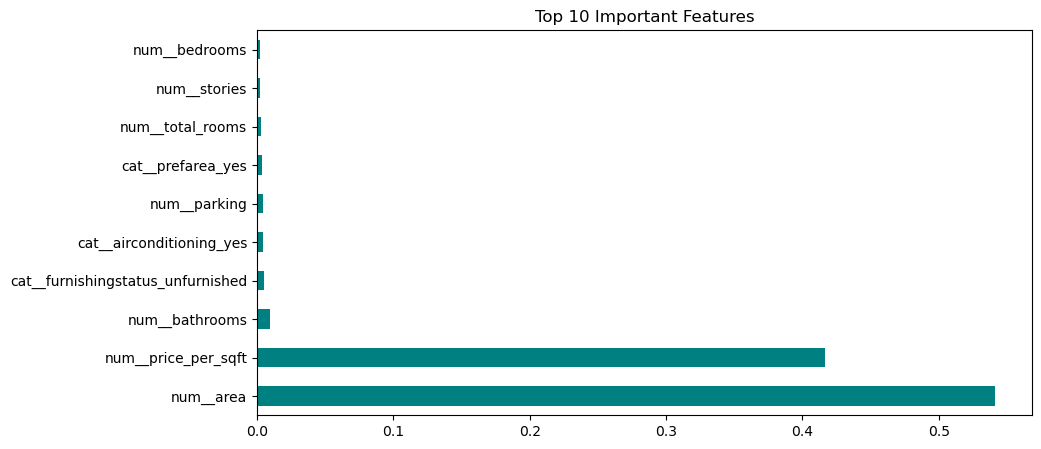

In [14]:
# Feature Importance Plot
plt.figure(figsize=(10, 5))
top_features.plot(kind="barh", color="teal")
plt.title("Top 10 Important Features")
plt.show()
